In [15]:
import glob
import os
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import metrics 


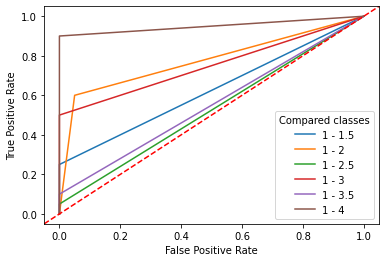

In [16]:
y_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]

# importing data
csv_file_zoe = pd.read_csv('labels_synth_zoe.csv', header=None)
csv_file_christof = pd.read_csv('labels_synth_christof.csv', header=None)

true_labels_zoe = np.array([y_list[int(picture[-5])] for picture in csv_file_zoe.iloc[0, :]])
predicted_labels_zoe = np.array([float(rating) for rating in csv_file_zoe.iloc[1, :]])

true_labels_christof = np.array([y_list[int(picture[-5])] for picture in csv_file_christof.iloc[0, :]])
predicted_labels_christof = np.array([float(rating) for rating in csv_file_christof.iloc[1, :]])

true_labels = np.concatenate((true_labels_zoe, true_labels_christof))
predicted_labels =  np.concatenate((predicted_labels_zoe, predicted_labels_christof))


for i in range(1, len(y_list)):
    # transform data
    df_lim = pd.DataFrame(true_labels)
    df_lim['true'] = pd.DataFrame(true_labels)
    df_lim['predict'] = pd.DataFrame(predicted_labels)
    df_check = df_lim.copy()
    
    baseline_class = 1; current_class = y_list[i]
    
    # slicing only the subset with both classes (baseline and specific class)
    df_lim = df_lim[(df_lim['true'] == baseline_class) | (df_lim['true'] == current_class)]
    df_lim['true'] = [1 if y == current_class else 0 for y in df_lim['true']]
    df_lim = df_lim.reset_index(drop = True)
    df_lim['predict'] = [1 if y == current_class else 0 for y in df_lim['predict']]
    
    # plot roc curve
    fpr, tpr, _ = metrics.roc_curve(df_lim['true'],  df_lim['predict'])
    plt.plot(fpr,tpr)
    
x = np.arange(0,1,0.1)
plt.axline((1, 1), slope=1, color='r', ls='--')
baseline_compare_classes = ['1 - 1.5', '1 - 2', '1 - 2.5', '1 - 3', '1 - 3.5', '1 - 4']
plt.legend(baseline_compare_classes, title = "Compared classes")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("roc_curves.png")
plt.show()


In [17]:
# correct response array
n_correct_responses = []
y_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]
for i in range(0, len(y_list)):
    true_class_loc = np.where(true_labels == y_list[i])
    predict_class_loc = np.where(predicted_labels == y_list[i])
    n_correct_responses.append((len(np.intersect1d(true_class_loc, predict_class_loc))))


In [18]:
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize

# high threshold log model
def guess(arguments):
    N = 10
    intensities = [1, 1.5, 2.0, 2.5, 3.0, 3.5, 4]
    sigma, c = arguments[0], arguments[1]
    result = 0
    for i in range(0, len(intensities)):
        n = n_correct_responses[i]
        I = intensities[i]
        P_guess = 1/3
        P_tilde = norm.cdf((I - c) / sigma)
        P_normal = P_tilde + (1 - P_tilde) * P_guess
        # first sum of equation
        first = 0
        for j in range(1, N+1):
            first += np.log(j)
        # second part of equation
        second = 0
        for k in range(1, n+1):
            second += np.log(k)
        # third part of equation
        third = 0
        for l in range (1, N+1 - n):
            third += np.log(l)
        fourth = n * np.log(P_normal) + (N - n) * np.log(1 - P_normal)
        result += first - second - third + fourth
    return -result

# minimizing negative log likelihood
x = [1,1]
sol = minimize(guess,x, method='Nelder-Mead')
print(sol)

 final_simplex: (array([[ 4.07301072e+14, -6.18999662e+14],
       [ 4.07295948e+14, -6.18991875e+14],
       [ 4.07316376e+14, -6.19022921e+14]]), array([51.15505408, 51.15505408, 51.15505408]))
           fun: 51.15505407964815
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 403
           nit: 207
        status: 1
       success: False
             x: array([ 4.07301072e+14, -6.18999662e+14])


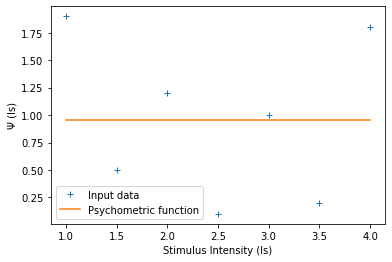

In [19]:
# analyzing psychometric function and raw data in a plot
N = 10
intensities = [1, 1.5, 2.0, 2.5, 3.0, 3.5, 4]
n_correct_responses = [19, 5, 12, 1, 10, 2, 18]

data_points = []
for i in range(0, len(intensities)):
    data_points.append(n_correct_responses[i]/N)


x = np.linspace(1,4,100)
sigma = sol.x[0]
c = sol.x[1]
P_guess = norm.cdf((x - c) / sigma) + (1 - norm.cdf((x - c) / sigma)) * 1/3
plt.plot(intensities, data_points, "+")
plt.plot(x, P_guess)
plt.ylabel("Ψ (Is)")
plt.xlabel("Stimulus Intensity (Is)")
plt.legend(["Input data", "Psychometric function"])
plt.savefig('psychometric_graph.png')